In [2]:
import argparse
import pandas as pd
import numpy as np
import os 

from matplotlib import pyplot as plt

In [95]:
input_path = "./data/raw/2023_set_n1/2023_01_04-00_16_30.csv"
df = pd.read_csv(input_path)
freq = [x for x in df.columns if "CL" in x]
data = df[freq].to_numpy()
time = 0.02 * np.arange(data.shape[0])


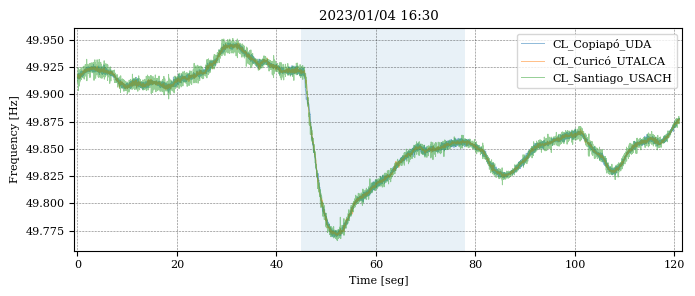

In [134]:
font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)
plt.rcParams['axes.xmargin'] = .005

fig = plt.figure(figsize=(7,3))

t0 = 45
tm = 78
plt.axvspan(t0, tm, alpha=.1)

plt.grid(color='k', linestyle='dotted', linewidth=.4)

plt.plot(time, data, alpha=.5, linewidth=.7)
plt.title("2023/01/04 16:30")
plt.xlabel("Time [seg]")
plt.ylabel("Frequency [Hz]")

plt.legend(freq)

#plt.text( 60.5, 49.815, 'Identification\nInterval', alpha=.3)

fig.tight_layout()

plt.savefig('./img/DataExample.pdf')

In [26]:
instance = "2023_01_05-00_21_20"
et = 15
model = "B2"
for i in range(10):
    et = et + 5
    output_dir = f"test/test_interval_exp_paper/{et}/"
    parameters = "30,0.56261,0.74232"
    if not os.path.isdir(output_dir):
                os.makedirs(output_dir)

    os.system(f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {output_dir} -et {et}")
    os.system(f"python src/de_run.py -i {output_dir}{instance}_sampled.csv -o {output_dir} -m {model} -p {parameters}")

In [11]:
import pickle
from scipy import signal

import sys
sys.path.insert(0, ".")
sys.path.insert(0, "./src/")
import models as mdl

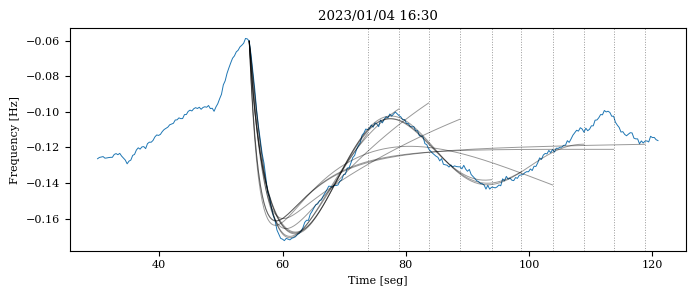

In [63]:
font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"
et = 15
model = "B2"

for i in range(10):
    et = et + 5
    output_dir = f"test/test_interval_exp_paper/{et}/"

    file = open(f"{output_dir}{instance}_sampled_result.p", 'rb')
    result = pickle.load(file)
    file.close()
    x = result.x
    df = pd.read_csv(f"{output_dir}{instance}_sampled.csv")  
    Ts = df["time"][1]
    P0 = -df["power"][0] / 1000
    event_freq = df["delta_freq"][df["event"]==1].to_numpy()

    if model == "b":
        sys = mdl.modelo_b(x, Ts)
    elif model == "c":
        sys = mdl.modelo_c(x, Ts)
    elif model == "cc":
        sys = mdl.modelo_cc(x, Ts)
        ########################################
    elif model == "A1":
        sys = mdl.modelo_A1(x, Ts)
    elif model == "A2":
        sys = mdl.modelo_A2(x, Ts)
    elif model == "B1":
        sys = mdl.modelo_B1(x, Ts)
    elif model == "B2":
        sys = mdl.modelo_B2(x, Ts)

    sim_power = P0 * np.repeat(1, event_freq.shape)
    sim = signal.dlsim(sys, sim_power, x0 = event_freq[0])
    sim_freq = sim[1].ravel()

    real_time = df["time"].to_numpy()
    real_freq = df["delta_freq"].to_numpy()

    event_time = df["time"][df["event"]==1].to_numpy()

    sim_time = np.linspace(event_time[0],event_time[-1],num=sim_freq.size)
    
    if i == 0:
        fig = plt.figure(figsize=(7,3))
        plt.plot(real_time[100:], real_freq[100:], linewidth=.7)
        plt.title("2023/01/04 16:30")
        plt.xlabel("Time [seg]")
        plt.ylabel("Frequency [Hz]")

    
    plt.plot(sim_time,sim_freq, alpha=.4, linewidth=.7, color = "k")
    plt.axvline(sim_time[-1], alpha=.4, linewidth=.7, color = "k", linestyle='dotted')

fig.tight_layout()
plt.savefig('./img/ExpIntervalSims.pdf')

In [36]:
instance = "2023_01_05-00_21_20"
et = 15

err = []
ets = []
for i in range(10):
    et = et + 5
    output_dir = f"test/test_interval_exp_paper/{et}/"

    file = open(f"{output_dir}{instance}_sampled_result.p", 'rb')
    result = pickle.load(file)
    file.close()
    err.append(result.fun/et)
    ets.append(et)
err

[2.3323061764217696e-05,
 2.1551529294582593e-05,
 0.00021182275826857778,
 0.0006046242094695941,
 5.1599385811628405e-05,
 4.842792650994225e-05,
 0.000493105789035144,
 5.035589799507013e-05,
 0.0006598760763037762,
 0.0006235388444705417]

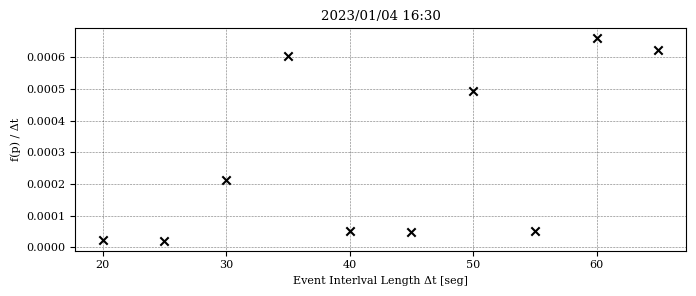

In [62]:
fig = plt.figure(figsize=(7,3))
plt.scatter(ets, err, color = "k", marker = "x")
plt.title("2023/01/04 16:30")
plt.xlabel("Event Interlval Length Δt [seg]")
plt.ylabel("f(p) / Δt")
plt.grid(color='k', linestyle='dotted', linewidth=.4)
fig.tight_layout()
plt.savefig('./img/ExpIntervalErrs.pdf')